In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import emoji 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


2024-05-06 05:50:58.289172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 05:50:58.289293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 05:50:58.455365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load data from DataFrame
data = pd.read_csv("/kaggle/input/analyze/text.csv") 
# Map labels to numerical classes (modify class names/indices as needed)
label_map = {'Sadness': 0, 'Joy': 1, 'Love': 2, 'Anger': 3, 'Fear': 4, 'Surprise': 5}
data["label"] = data["label"].replace(label_map)

# Replace numerical labels with emotion names (modify as needed)
emotion_map = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
data["label"] = data["label"].replace(emotion_map)

print(data)



        Unnamed: 0                                               text  \
0                0      i just feel really helpless and heavy hearted   
1                1  ive enjoyed being able to slouch about relax a...   
2                2  i gave up my internship with the dmrg and am f...   
3                3                         i dont know i feel so lost   
4                4  i am a kindergarten teacher and i am thoroughl...   
...            ...                                                ...   
416804      416804  i feel like telling these horny devils to find...   
416805      416805  i began to realize that when i was feeling agi...   
416806      416806  i feel very curious be why previous early dawn...   
416807      416807  i feel that becuase of the tyranical nature of...   
416808      416808  i think that after i had spent some time inves...   

           label  
0           Fear  
1        Sadness  
2           Fear  
3        Sadness  
4           Fear  
...      

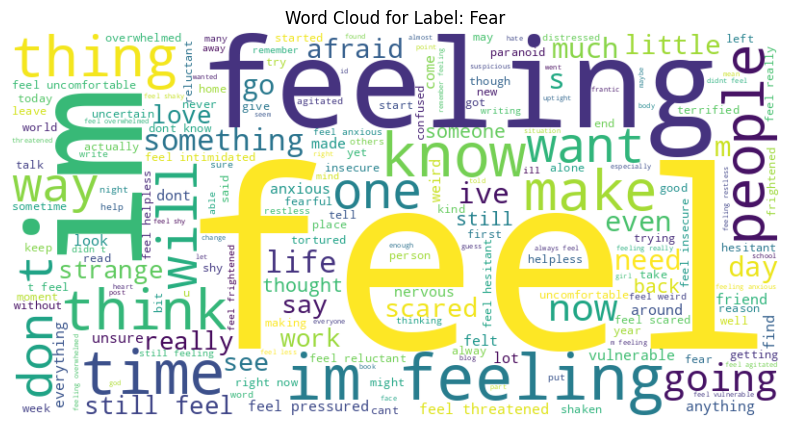

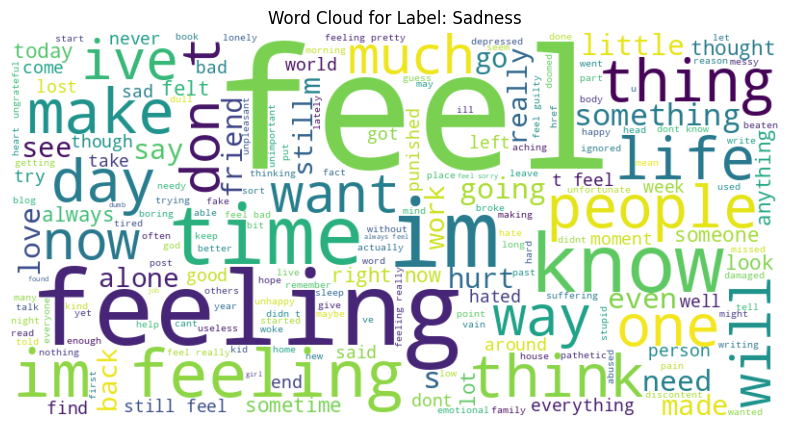

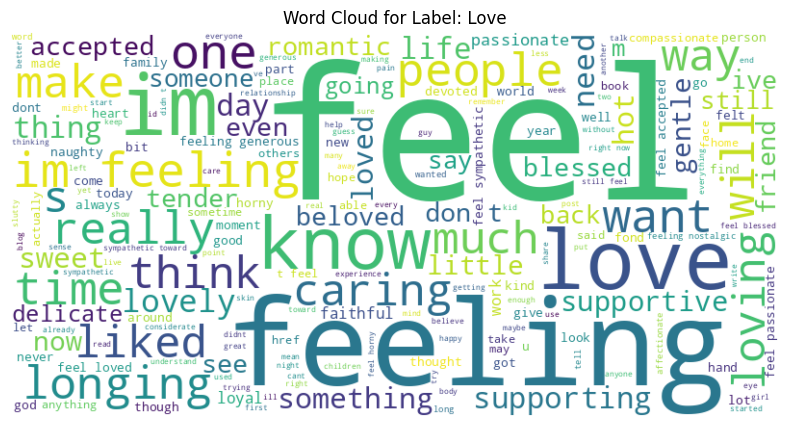

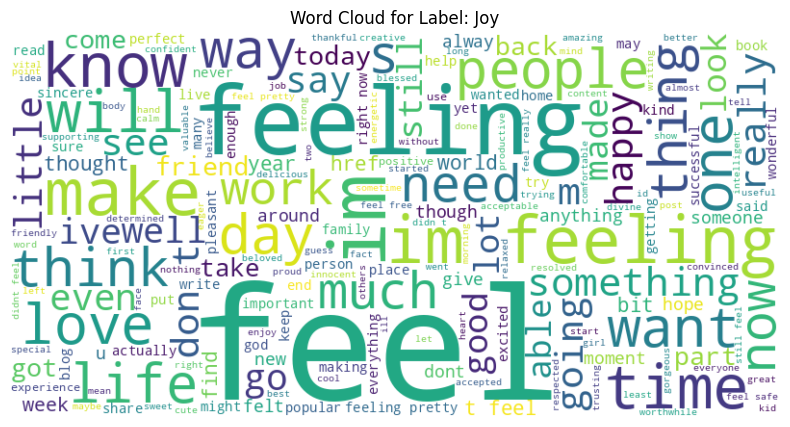

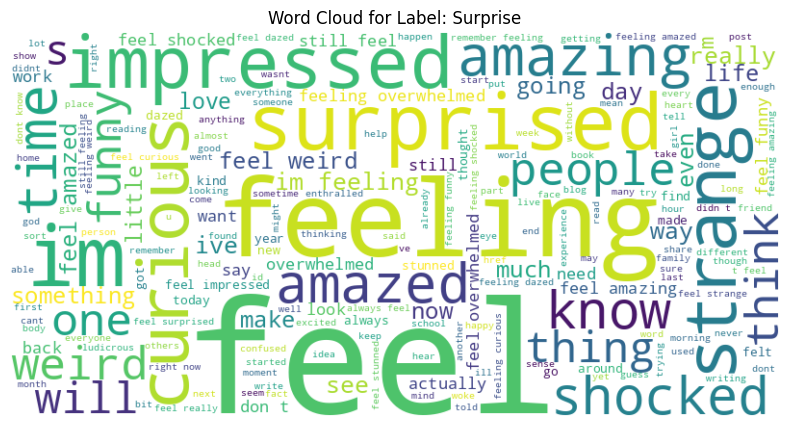

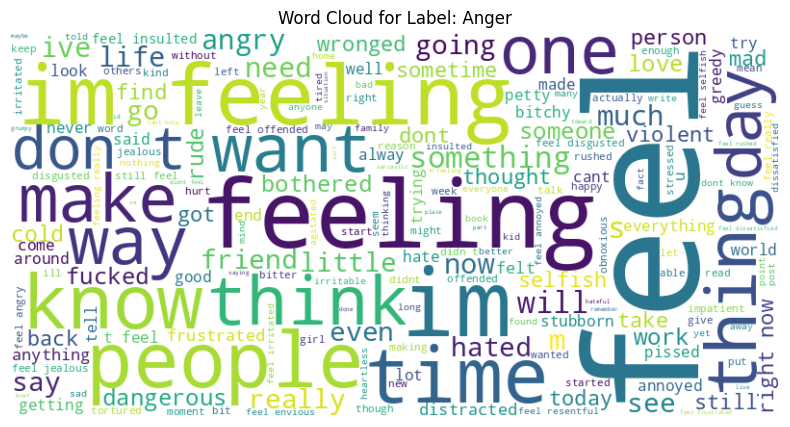

In [3]:
# Iterate through unique labels
for label in data['label'].unique():
    # Filter the DataFrame for the current label
    filtered_df = data[data['label'] == label]
    
    # Concatenate all text data for the current label
    text = ' '.join(filtered_df['text'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()

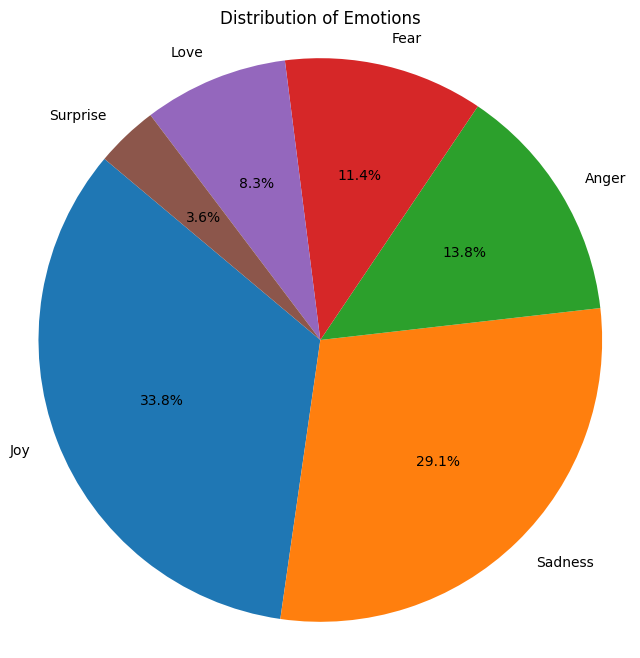

In [4]:
# Calculate the count of each label
label_counts = data['label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotions')
plt.axis('equal')
plt.show()

In [5]:
text_data = data["text"].tolist()
labels = data["label"].tolist()

# Label encoding
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
num_classes = len(le.classes_)  # Number of unique emotions

In [6]:
# Hyperparameters (adjust as needed)
max_len = 100  
vocab_size = 10000 
embedding_dim = 128  
lstm_units = 64 
batch_size = 32
epochs = 10

In [7]:
# Tokenization
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)


In [8]:
# Padding sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=109)


In [10]:
emotion_names = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]


In [11]:
# Naive Bayes
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)

nb_predictions = nb_model.predict(X_test)  # Make predictions on test data
nb_report = classification_report(y_test, nb_predictions, target_names=emotion_names)
print("Naive Bayes Report:\n", nb_report)

Naive Bayes Report:
               precision    recall  f1-score   support

     Sadness       0.14      0.11      0.12     11376
         Joy       0.11      0.11      0.11      9507
        Love       0.34      0.21      0.26     28394
       Anger       0.10      0.20      0.13      6854
        Fear       0.30      0.30      0.30     24279
    Surprise       0.04      0.12      0.06      2952

    accuracy                           0.21     83362
   macro avg       0.17      0.18      0.16     83362
weighted avg       0.25      0.21      0.22     83362



In [12]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)  # Make predictions on test data
rf_report = classification_report(y_test, rf_predictions, target_names=emotion_names)
print("Random Forest Report:\n", rf_report)

Random Forest Report:
               precision    recall  f1-score   support

     Sadness       0.24      0.05      0.08     11376
         Joy       0.14      0.03      0.05      9507
        Love       0.38      0.70      0.49     28394
       Anger       0.05      0.01      0.02      6854
        Fear       0.39      0.39      0.39     24279
    Surprise       0.03      0.01      0.02      2952

    accuracy                           0.36     83362
   macro avg       0.21      0.20      0.17     83362
weighted avg       0.30      0.36      0.30     83362



In [13]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)  # Make predictions on test data
dt_report = classification_report(y_test, dt_predictions, target_names=emotion_names)
print("Decision Tree Report:\n", dt_report)

Decision Tree Report:
               precision    recall  f1-score   support

     Sadness       0.28      0.29      0.28     11376
         Joy       0.22      0.24      0.23      9507
        Love       0.45      0.45      0.45     28394
       Anger       0.17      0.16      0.16      6854
        Fear       0.45      0.43      0.44     24279
    Surprise       0.12      0.13      0.13      2952

    accuracy                           0.37     83362
   macro avg       0.28      0.28      0.28     83362
weighted avg       0.37      0.37      0.37     83362



In [14]:
# Define the BiGRU model
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Bidirectional(LSTM(lstm_units)),
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])


In [15]:
# Compile the model
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history=model.fit(padded_sequences, tf.keras.utils.to_categorical(encoded_labels, num_classes), epochs=epochs, batch_size=batch_size)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13026/13026 ━━━━━━━━━━━━━━━━━━━━ 214s 16ms/step - accuracy: 0.8734 - loss: 0.2957
Epoch 2/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 211s 16ms/step - accuracy: 0.9412 - loss: 0.0916
Epoch 3/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 264s 16ms/step - accuracy: 0.9424 - loss: 0.0870
Epoch 4/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 260s 16ms/step - accuracy: 0.9434 - loss: 0.0840
Epoch 5/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 210s 16ms/step - accuracy: 0.9432 - loss: 0.0826
Epoch 6/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 262s 16ms/step - accuracy: 0.9438 - loss: 0.0811
Epoch 7/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 210s 16ms/step - accuracy: 0.9443 - loss: 0.0803
Epoch 8/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 210s 16ms/step - accuracy: 0.9442 - loss: 0.0796
Epoch 9/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 211s 16ms/step - accuracy: 0.9448 - loss: 0.0790
Epoch 10/10
13026/13026 ━━━━━━━━━━━━━━━━━━━━ 211s 16ms/step - accuracy: 0.9447 - loss: 0.0785


In [17]:
# Evaluate the model (optional)
loss, accuracy = model.evaluate(padded_sequences, tf.keras.utils.to_categorical(encoded_labels, num_classes), verbose=0)
print("Test Loss:", loss, "Test Accuracy:", accuracy)

Test Loss: 0.07728667557239532 Test Accuracy: 0.9453250765800476


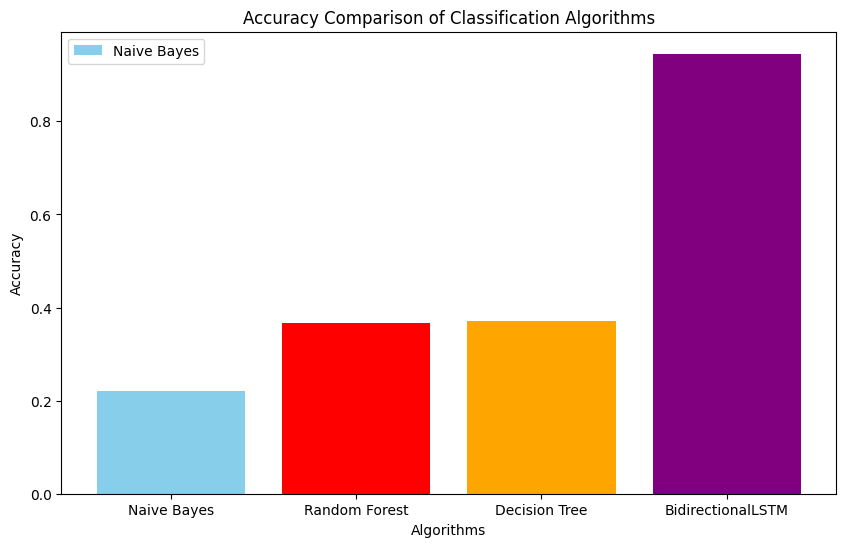

In [18]:
import matplotlib.pyplot as plt

# Accuracy for different algorithms
accuracy = [0.2199, 0.367, 0.37, 0.9452]  

# Algorithm names
algorithms = ['Naive Bayes', 'Random Forest', 'Decision Tree', 'BidirectionalLSTM']

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(algorithms, accuracy, color=['skyblue', 'red', 'orange', 'purple'])
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Classification Algorithms')

# Improved legend with algorithm names
plt.legend(algorithms, loc='upper left')  # Legend position can be adjusted

plt.show()


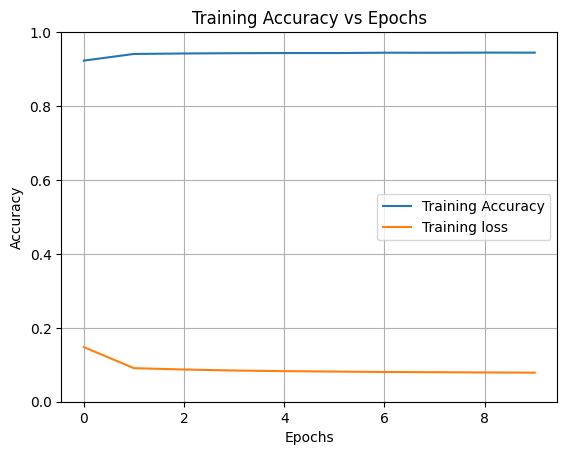

In [19]:
# Plotting the training and testing accuracy
train_accuracy = history.history['accuracy']
epochs = np.arange(len(train_accuracy))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs,history.history['loss'],label='Training loss')

plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [20]:
loss, accuracy = model.evaluate(padded_sequences, tf.keras.utils.to_categorical(encoded_labels, num_classes), verbose=0)
print("Test Loss:", loss, "Test Accuracy:", accuracy)

Test Loss: 0.07728667557239532 Test Accuracy: 0.9453250765800476


In [21]:
# Predict on test data
predictions = model.predict(padded_sequences)

13026/13026 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert predictions to one-hot encoded labels
predicted_labels = tf.math.argmax(predictions, axis=1)

# Generate confusion matrix
confusion_matrix_result = confusion_matrix(encoded_labels, predicted_labels)
print("Confusion Matrix:\n", confusion_matrix_result)

# Generate classification report
classification_report_result = classification_report(encoded_labels, predicted_labels, target_names=emotion_names)
print("Classification Report:\n", classification_report_result)


Confusion Matrix:
 [[ 52423   2189      4      0   2701      0]
 [    68  45486      4      0   2150      4]
 [    29     12 139720     10     16   1280]
 [     0      0  10118  24436      0      0]
 [    52     13      7      1 121092     22]
 [     0   4011      6      0     92  10863]]
Classification Report:
               precision    recall  f1-score   support

     Sadness       1.00      0.91      0.95     57317
         Joy       0.88      0.95      0.91     47712
        Love       0.93      0.99      0.96    141067
       Anger       1.00      0.71      0.83     34554
        Fear       0.96      1.00      0.98    121187
    Surprise       0.89      0.73      0.80     14972

    accuracy                           0.95    416809
   macro avg       0.94      0.88      0.91    416809
weighted avg       0.95      0.95      0.94    416809



In [23]:
# Predict on new text data
new_text = "i dont know i feel so lost"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
prediction = model.predict(new_padded_sequence)
predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index
predicted_emotion = le.inverse_transform(np.array([predicted_class]))[0]  # Decode back to emotion


emotion_to_emoji = {"Sadness": "😒", "Joy": "😀", "Love": "😍", "Anger": "😣", "Fear": "😨", "Surprise": "😯"}
output=emotion_to_emoji[predicted_emotion]
print("Predicted Emotion for new text:", predicted_emotion)
print("Predicted Emotion for new text:", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotion for new text: Sadness
Predicted Emotion for new text: 😒


In [24]:
# Predict on new text data
new_text = "i feel triumphant for some reason"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
prediction = model.predict(new_padded_sequence)
predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index
predicted_emotion = le.inverse_transform(np.array([predicted_class]))[0]  # Decode back to emotion


emotion_to_emoji = {"Sadness": "😒", "Joy": "😀", "Love": "😍", "Anger": "😣", "Fear": "😨", "Surprise": "😯"}
output=emotion_to_emoji[predicted_emotion]
print("Predicted Emotion for new text:", predicted_emotion)
print("Predicted Emotion for new text:", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion for new text: Joy
Predicted Emotion for new text: 😀


In [25]:
# Predict on new text data
new_text = "i feel very loved lt"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
prediction = model.predict(new_padded_sequence)
predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index
predicted_emotion = le.inverse_transform(np.array([predicted_class]))[0]  # Decode back to emotion


emotion_to_emoji = {"Sadness": "😒", "Joy": "😀", "Love": "😍", "Anger": "😣", "Fear": "😨", "Surprise": "😯"}
output=emotion_to_emoji[predicted_emotion]
print("Predicted Emotion for new text:", predicted_emotion)
print("Predicted Emotion for new text:", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion for new text: Love
Predicted Emotion for new text: 😍


In [26]:
# Predict on new text data
new_text = "i feel a bit of furious that time"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
prediction = model.predict(new_padded_sequence)
predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index
predicted_emotion = le.inverse_transform(np.array([predicted_class]))[0]  # Decode back to emotion


emotion_to_emoji = {"Sadness": "😒", "Joy": "😀", "Love": "😍", "Anger": "😣", "Fear": "😨", "Surprise": "😯"}
output=emotion_to_emoji[predicted_emotion]
print("Predicted Emotion for new text:", predicted_emotion)
print("Predicted Emotion for new text:", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion for new text: Anger
Predicted Emotion for new text: 😣


In [27]:
# Predict on new text data
new_text = "im feeling frightened and i dont know how to handle this"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
prediction = model.predict(new_padded_sequence)
predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index
predicted_emotion = le.inverse_transform(np.array([predicted_class]))[0]  # Decode back to emotion


emotion_to_emoji = {"Sadness": "😒", "Joy": "😀", "Love": "😍", "Anger": "😣", "Fear": "😨", "Surprise": "😯"}
output=emotion_to_emoji[predicted_emotion]
print("Predicted Emotion for new text:", predicted_emotion)
print("Predicted Emotion for new text:", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion for new text: Fear
Predicted Emotion for new text: 😨


In [28]:
# Predict on new text data
new_text = "i am feel curious"
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
prediction = model.predict(new_padded_sequence)
predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index
predicted_emotion = le.inverse_transform(np.array([predicted_class]))[0]  # Decode back to emotion


emotion_to_emoji = {"Sadness": "😒", "Joy": "😀", "Love": "😍", "Anger": "😣", "Fear": "😨", "Surprise": "😯"}
output=emotion_to_emoji[predicted_emotion]
print("Predicted Emotion for new text:", predicted_emotion)
print("Predicted Emotion for new text:", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion for new text: Surprise
Predicted Emotion for new text: 😯
